In [1]:
from models.graph_su import *

In [2]:
import os
import utils.io as io

class SurgicalSceneConstants():
    def __init__( self):
        self.instrument_classes = ('kidney', 'bipolar_forceps', 'prograsp_forceps', 'large_needle_driver',
                      'monopolar_curved_scissors', 'ultrasound_probe', 'suction', 'clip_applier',
                      'stapler', 'maryland_dissector', 'spatulated_monopolar_cautery')
        
        self.action_classes = ( 'Idle', 'Grasping', 'Retraction', 'Tissue_Manipulation', 
                                'Tool_Manipulation', 'Cutting', 'Cauterization', 
                                'Suction', 'Looping', 'Suturing', 'Clipping', 'Staple', 
                                'Ultrasound_Sensing')
        self.xml_data_dir = 'datasets/instruments18/seq_'
        self.word2vec_loc = 'datasets/surgicalscene_word2vec.hdf5'

In [3]:
import sys
import random

import h5py
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import os
from glob import glob
    
class SurgicalSceneDataset(Dataset):
    '''
    '''
    def __init__(self, seq_set, data_dir, img_dir, dset, dataconst, feature_extractor, reduce_size = False):
        
        
        self.data_size = 143
        self.dataconst = dataconst
        self.img_dir = img_dir
        self.feature_extractor = feature_extractor
        self.reduce_size = reduce_size
        
        self.xml_dir_list = []
        self.dset = []
        
        for domain in range(len(seq_set)):
            domain_dir_list = []
            for i in seq_set[domain]:
                xml_dir_temp = data_dir[domain] + str(i) + '/xml/'
                domain_dir_list = domain_dir_list + glob(xml_dir_temp + '/*.xml')
            if self.reduce_size:
                indices = np.random.permutation(len(domain_dir_list))
                domain_dir_list = [domain_dir_list[j] for j in indices[0:self.data_size]]
            for file in domain_dir_list: 
                self.xml_dir_list.append(file)
                self.dset.append(dset[domain])
        self.word2vec = h5py.File('datasets/surgicalscene_word2vec.hdf5', 'r')
    
    # word2vec
    def _get_word2vec(self,node_ids, sgh = 0):
        word2vec = np.empty((0,300))
        for node_id in node_ids:
            if sgh == 1 and node_id == 0:
                vec = self.word2vec['tissue']
            else:
                vec = self.word2vec[self.dataconst.instrument_classes[node_id]]
            word2vec = np.vstack((word2vec, vec))
        return word2vec

    def __len__(self):
        return len(self.xml_dir_list)

    def __getitem__(self, idx):
    
        file_name = os.path.splitext(os.path.basename(self.xml_dir_list[idx]))[0]
        file_root = os.path.dirname(os.path.dirname(self.xml_dir_list[idx]))
        if len(self.img_dir) == 1:
            _img_loc = os.path.join(file_root+self.img_dir[0]+ file_name + '.png')
        else:
            _img_loc = os.path.join(file_root+self.img_dir[self.dset[idx]]+ file_name + '.png')
        frame_data = h5py.File(os.path.join(file_root+'/vsgat/'+self.feature_extractor+'/'+ file_name + '_features.hdf5'), 'r')    
        data = {}
        data['img_name'] = frame_data['img_name'].value[:] + '.jpg'
        data['img_loc'] = _img_loc
        
        data['node_num'] = frame_data['node_num'].value
        data['roi_labels'] = frame_data['classes'][:]
        data['det_boxes'] = frame_data['boxes'][:]
        
        
        data['edge_labels'] = frame_data['edge_labels'][:]
        data['edge_num'] = data['edge_labels'].shape[0]
        
        data['features'] = frame_data['node_features'][:]
        data['spatial_feat'] = frame_data['spatial_features'][:]
        
        
        data['word2vec'] = self._get_word2vec(data['roi_labels'], self.dset[idx])
        return data

# for DatasetLoader
def collate_fn(batch):
    '''
        Default collate_fn(): https://github.com/pytorch/pytorch/blob/1d53d0756668ce641e4f109200d9c65b003d05fa/torch/utils/data/_utils/collate.py#L43
    '''
    batch_data = {}
    batch_data['img_name'] = []
    batch_data['img_loc'] = []
    batch_data['node_num'] = []
    batch_data['roi_labels'] = []
    batch_data['det_boxes'] = []
    batch_data['edge_labels'] = []
    batch_data['edge_num'] = []
    batch_data['features'] = []
    batch_data['spatial_feat'] = []
    batch_data['word2vec'] = []
    
    for data in batch:
        batch_data['img_name'].append(data['img_name'])
        batch_data['img_loc'].append(data['img_loc'])
        batch_data['node_num'].append(data['node_num'])
        batch_data['roi_labels'].append(data['roi_labels'])
        batch_data['det_boxes'].append(data['det_boxes'])
        batch_data['edge_labels'].append(data['edge_labels'])
        batch_data['edge_num'].append(data['edge_num'])
        batch_data['features'].append(data['features'])
        batch_data['spatial_feat'].append(data['spatial_feat'])
        batch_data['word2vec'].append(data['word2vec'])
        
    batch_data['edge_labels'] = torch.FloatTensor(np.concatenate(batch_data['edge_labels'], axis=0))
    batch_data['features'] = torch.FloatTensor(np.concatenate(batch_data['features'], axis=0))
    batch_data['spatial_feat'] = torch.FloatTensor(np.concatenate(batch_data['spatial_feat'], axis=0))
    batch_data['word2vec'] = torch.FloatTensor(np.concatenate(batch_data['word2vec'], axis=0))
    
    return batch_data

In [4]:
import time

import random
import numpy as np
import matplotlib
import torch as t

matplotlib.use('Agg')
from matplotlib import pyplot as plot
from PIL import Image, ImageDraw, ImageFont


def vis_img(img, node_classes, bboxs,  det_action, score_thresh = 0.7):
    
    Drawer = ImageDraw.Draw(img)
    line_width = 3
    outline = '#FF0000'
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/freefont/FreeMono.ttf', size=25)
    
    im_w,im_h = img.size
    node_num = len(node_classes)
    edge_num = len(det_action)
    tissue_num = len(np.where(node_classes == 1)[0])
    
    for node in range(node_num):
        
        r_color = random.choice(np.arange(256))
        g_color = random.choice(np.arange(256))
        b_color = random.choice(np.arange(256))
        
        text = data_const.instrument_classes[node_classes[node]]
        h, w = font.getsize(text)
        Drawer.rectangle(list(bboxs[node]), outline=outline, width=line_width)
        Drawer.text(xy=(bboxs[node][0], bboxs[node][1]-w-1), text=text, font=font, fill=(r_color,g_color,b_color))
  
    edge_idx = 0
    
    for tissue in range(tissue_num):
        for instrument in range(tissue+1, node_num):
            
            #action_idx = np.where(det_action[edge_idx] > score_thresh)[0]
            action_idx = np.argmax(det_action[edge_idx])
#             print('det_action', det_action[edge_idx])
#             print('action_idx',action_idx)
            
            text = data_const.action_classes[action_idx]
            r_color = random.choice(np.arange(256))
            g_color = random.choice(np.arange(256))
            b_color = random.choice(np.arange(256))
        
            x1,y1,x2,y2 = bboxs[tissue]
            x1_,y1_,x2_,y2_ = bboxs[instrument]
            
            c0 = int(0.5*x1)+int(0.5*x2)
            c0 = max(0,min(c0,im_w-1))
            r0 = int(0.5*y1)+int(0.5*y2)
            r0 = max(0,min(r0,im_h-1))
            c1 = int(0.5*x1_)+int(0.5*x2_)
            c1 = max(0,min(c1,im_w-1))
            r1 = int(0.5*y1_)+int(0.5*y2_)
            r1 = max(0,min(r1,im_h-1))
            Drawer.line(((c0,r0),(c1,r1)), fill=(r_color,g_color,b_color), width=3)
            Drawer.text(xy=(c1, r1), text=text, font=font, fill=(r_color,g_color,b_color))

            edge_idx +=1

    return img

In [5]:
import os
import random
import numpy as np
import torch
import sklearn.metrics

import matplotlib.pyplot as plt
%matplotlib inline

def ece_eval(preds, targets, n_bins=10, bg_cls = 0):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    confidences, predictions = np.max(preds,1), np.argmax(preds,1)
    confidences, predictions = confidences[targets>bg_cls], predictions[targets>bg_cls]
    accuracies = (predictions == targets[targets>bg_cls]) 
    Bm, acc, conf = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)
    ece = 0.0
    bin_idx = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        #in_bin = in_bin[targets>backgound_class]
        bin_size = np.sum(in_bin)
        
        Bm[bin_idx] = bin_size
        if bin_size > 0:  
            accuracy_in_bin = np.sum(accuracies[in_bin])
            acc[bin_idx] = accuracy_in_bin / Bm[bin_idx]
            confidence_in_bin = np.sum(confidences[in_bin])
            conf[bin_idx] = confidence_in_bin / Bm[bin_idx]
        bin_idx += 1
        
    ece_all = Bm * np.abs((acc - conf))/ Bm.sum()
    ece = ece_all.sum() 
    return ece, acc, conf, Bm

def get_sce(preds, targets, n_bins=10, **args):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    n_objects, n_classes = preds.shape
    res = 0.0
    for cur_class in range(n_classes):
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            cur_class_conf = preds[:, cur_class]
            in_bin = np.logical_and(cur_class_conf > bin_lower, cur_class_conf <= bin_upper)

            # cur_class_acc is ground truth probability of chosen class being the correct one inside the bin.
            # NOT fraction of correct predictions in the bin
            # because it is compared with predicted probability
            bin_acc = (targets[in_bin] == cur_class)
            
            bin_conf = cur_class_conf[in_bin]

            bin_size = np.sum(in_bin)
            
            if bin_size > 0:
                avg_confidence_in_bin = np.mean(bin_conf)
                avg_accuracy_in_bin = np.mean(bin_acc)
                delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#                 print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
                res += delta * bin_size / (n_objects * n_classes)
    return res

def get_tace(preds, targets, n_bins=15, threshold=1e-3, **args):
    n_objects, n_classes = preds.shape
    
    res = 0.0
    for cur_class in range(n_classes):
        cur_class_conf = preds[:, cur_class]
        
        targets_sorted = targets[cur_class_conf.argsort()]
        cur_class_conf_sorted = np.sort(cur_class_conf)
        
        targets_sorted = targets_sorted[cur_class_conf_sorted > threshold]
        cur_class_conf_sorted = cur_class_conf_sorted[cur_class_conf_sorted > threshold]
        
        bin_size = len(cur_class_conf_sorted) // n_bins
                
        for bin_i in range(n_bins):
            bin_start_ind = bin_i * bin_size
            if bin_i < n_bins-1:
                bin_end_ind = bin_start_ind + bin_size
            else:
                bin_end_ind = len(targets_sorted)
                bin_size = bin_end_ind - bin_start_ind  # extend last bin until the end of prediction array
            bin_acc = (targets_sorted[bin_start_ind : bin_end_ind] == cur_class)
            bin_conf = cur_class_conf_sorted[bin_start_ind : bin_end_ind]
            avg_confidence_in_bin = np.mean(bin_conf)
            avg_accuracy_in_bin = np.mean(bin_acc)
            delta = np.abs(avg_confidence_in_bin - avg_accuracy_in_bin)
#             print(f'bin size {bin_size}, bin conf {avg_confidence_in_bin}, bin acc {avg_accuracy_in_bin}')
            res += delta * bin_size / (n_objects * n_classes)
            
    return res

def get_brier(preds, targets, **args):
    one_hot_targets = np.zeros(preds.shape)
    one_hot_targets[np.arange(len(targets)), targets] = 1.0
    return np.mean(np.sum((preds - one_hot_targets) ** 2, axis=1))

def nentr(p, base=None):
    """
    Calculates entropy of p to the base b. If base is None, the natural logarithm is used.
    :param p: batches of class label probability distributions (softmax output)
    :param base: base b
    :return:
    """
    eps = torch.tensor([1e-16], device=p.device)
    if base:
        base = torch.tensor([base], device=p.device, dtype=torch.float32)
        return (p.mul(p.add(eps).log().div(base.log()))).sum(dim=1).abs()
    else:
        return (p.mul(p.add(eps).log())).sum(dim=1).abs()

def uceloss(softmaxes, labels, n_bins=15):
    d = softmaxes.device
    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=d)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    _, predictions = torch.max(softmaxes, 1)
    _, labels = torch.max(labels, 1)
    errors = predictions.ne(labels)
    uncertainties = nentr(softmaxes, base=softmaxes.size(1))
    errors_in_bin_list = []
    avg_entropy_in_bin_list = []

    uce = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculate |uncert - err| in each bin
        in_bin = uncertainties.gt(bin_lower.item()) * uncertainties.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > 0.0:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_entropy_in_bin = uncertainties[in_bin].mean()  # uncert()
            uce += torch.abs(avg_entropy_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_entropy_in_bin_list.append(avg_entropy_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=d)
    avg_entropy_in_bin = torch.tensor(avg_entropy_in_bin_list, device=d)

    return uce#, err_in_bin, avg_entropy_in_bin

def compute_mean_avg_prec(y_true, y_score):
    try:
        avg_prec = sklearn.metrics.average_precision_score(y_true, y_score, average=None)
        mean_avg_prec = np.nansum(avg_prec) / len(avg_prec)
    except ValueError:
        mean_avg_prec = 0

    return mean_avg_prec

def reliability_diagram_multi(conf_avg, acc_avg, rdname, legend=None, leg_idx=0, n_bins=10):
    #plt.clf()
    plt.figure(2)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, 1.1, 1/n_bins))
    #plt.title(title)
    plt.plot(conf_avg[acc_avg>0],acc_avg[acc_avg>0], marker='.', label = legend)
    plt.legend()
    #plt.savefig('figures/reliability_diagram/'+rdname+'ece_rel_multi.png',dpi=300)
    plt.savefig('figures/'+rdname+'ece_rel_multi.png',dpi=300)

def calibration_metrics(logits_all, labels_all, rdname, plot=False, model_name='graph_network'):
    uce = uceloss( logits_all.cpu(), labels_all.cpu())
    
    logits = logits_all.detach().cpu().numpy()
    labels = labels_all.detach().cpu().numpy()
    map_value = compute_mean_avg_prec(labels, logits)
    
    labels = np.argmax(labels, axis=-1)
    ece, acc, conf, Bm = ece_eval(logits, labels, bg_cls=-1)
    sce = get_sce(logits, labels)
    tace = get_tace(logits, labels)
    brier = get_brier(logits, labels)
    #print('%s:, ece:%0.4f, sce:%0.4f, tace:%0.4f, brier:%.4f, uce:%.4f' %(model_name, ece, sce, tace, brier, uce.item()) )
    if plot: reliability_diagram_multi(conf, acc, rdname, legend=model_name)
    return(map_value, ece, sce, tace, brier, uce)

In [6]:
from __future__ import print_function

import os
import copy
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import utils.io as io


import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader


def seed_everything(seed=27):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def calculate_cls_freq(dataloader, num_classes):
    cls_freq = np.zeros((num_classes,1))
    for data in dataloader:
        edge_labels = data['edge_labels']
        edge_labels = np.argmax(edge_labels.cpu().data.numpy(), axis=-1)    
        for i in edge_labels:
            cls_freq[i] += 1
    return cls_freq

def evaluate(args, data_const, model, seq, device, dname, rdname, plot_name = 'graph',plot = False):
    '''

    '''
    train_dataset = SurgicalSceneDataset(seq_set = seq['train_seq'], data_dir = seq['data_dir'], \
                            img_dir = seq['img_dir'], dset = seq['dset'], dataconst = data_const, \
                            feature_extractor = args.feature_extractor, reduce_size = False)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle= True, \
                            collate_fn=collate_fn)
    
    val_dataset = SurgicalSceneDataset(seq_set = seq['val_seq'], data_dir = seq['data_dir'], \
                            img_dir = seq['img_dir'], dset = seq['dset'], dataconst = data_const, \
                            feature_extractor = args.feature_extractor, reduce_size = False)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size= 2, shuffle= True, \
                            collate_fn=collate_fn)
    
    # model evaluate
    model.eval()
    
    # criterion and scheduler
    criterion = nn.MultiLabelSoftMarginLoss()

    # each epoch has a training and validation step                   
    edge_count = 0
    total_acc = 0.0
    total_loss = 0.0
    logits_list = []
    labels_list = []
    start_time = time.time()
    
    if args.use_cda_t:
        cls_freq = calculate_cls_freq(train_dataloader, len(data_const.action_classes))
        cls_freq_log = torch.tensor(cls_freq).log()
        cls_freq_log_norm = cls_freq_log/cls_freq_log.max()
        temp = args.t_scale - (1-cls_freq_log_norm.view(-1))
        #print(temp)
        temp = temp.to(device)
    
    for data in val_dataloader:
        train_data = data
        img_name = train_data['img_name']
        img_loc = train_data['img_loc']
        node_num = train_data['node_num']
        roi_labels = train_data['roi_labels']
        det_boxes = train_data['det_boxes']
        edge_labels = train_data['edge_labels']
        edge_num = train_data['edge_num']
        features = train_data['features']
        spatial_feat = train_data['spatial_feat']
        word2vec = train_data['word2vec']
        features, spatial_feat, word2vec, edge_labels = features.to(device), spatial_feat.to(device), word2vec.to(device), edge_labels.to(device)    
            
        #if img_name[0] == 'frame123.jpg':
            #print(edge_labels)
        with torch.no_grad():
            
            
            #print('node_num', node_num)
            #print('node_feat', features.shape)
            #print('spatial_deat', spatial_feat.shape)
            #print('word_2_vec', word2vec.shape)
            #print('roi_labels', roi_labels)
        
            outputs = model(node_num, features, spatial_feat, word2vec, roi_labels, validation=True)
            
            print(outputs)
            
            if args.use_t: outputs/args.t_scale
            elif args.use_cda_t: outputs = outputs/temp

            logits_list.append(outputs)
            labels_list.append(edge_labels)       
            
            # loss and accuracy
            loss = criterion(outputs, edge_labels.float())
            acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), np.argmax(edge_labels.cpu().data.numpy(), axis=-1)))
            
#             if img_name[0] == 'frame123.jpg':
#                 print(np.argmax(edge_labels.cpu().data.numpy(), axis=-1))
#                 print(np.argmax(outputs.cpu().data.numpy(), axis=-1))
        # accumulate loss and accuracy of the batch
        total_loss += loss.item() * edge_labels.shape[0]
        total_acc  += acc
        edge_count += edge_labels.shape[0]
    
    logits_all = torch.cat(logits_list).cuda()
    labels_all = torch.cat(labels_list).cuda()
    
    # calculate the loss and accuracy
    total_acc = total_acc / edge_count
    total_loss = total_loss / len(val_dataloader)
    
    end_time = time.time()
    
    logits_all = F.softmax(logits_all, dim=1)
    map_value, ece, sce, tace, brier, uce = calibration_metrics(logits_all, labels_all, rdname, plot=plot, model_name=plot_name)
    print('acc: %0.6f map: %0.6f loss: %0.6f, ece:%0.6f, sce:%0.6f, tace:%0.6f, brier:%.6f, uce:%.6f' %(total_acc, map_value, total_loss, ece, sce, tace, brier, uce.item()) )

In [7]:
'''
arguments
    Hyperparameters, file location, optimizer, network, data_processing
'''
ver = 'da_ecbs_resnet18_09_SC_eCBS'
f_e = 'resnet18_09_SC_CBS'

class arguments():
    def __init__(self):

        self.batch_size = 32

        # network
        self.layers= 1
        self.bn = False
        self.drop_prob = 0.3
        self.bias = True
        self.multi_attn = False
        self.diff_edge = False

        # data_processing
        self.sampler = 0
        self.data_aug = False
        self.feature_extractor = f_e
        
        # CBS
        self.use_cbs = True
        
        # temperature_scaling
        self.use_t = False
        self.use_cda_t = False
        self.t_scale = 1.5
        
        self.testset = [1]#,2,12]

if __name__ == "__main__":
    
    seed_everything()
    args = arguments()
    data_const = SurgicalSceneConstants()
    
    for domain in args.testset:
        # val dataset
        if domain == 1:
            train_seq = [[2,3,4,6,7,9,10,11,12,14,15]]
            val_seq = [[1,5,16]]
            data_dir = ['datasets/instruments18/seq_']
            img_dir = ['/left_frames/']
            dset = [0]
            seq = {'train_seq': train_seq, 'val_seq': val_seq, 'data_dir': data_dir, 'img_dir':img_dir, 'dset': dset}

        elif domain == 2:
            train_seq = [[14,15,16,17,18,19,21,22]]
            val_seq = [[1,2,3,4,5,6,7,8,9,10,11,12,13,20]]
            data_dir = ['datasets/SGH_dataset_2020/']
            img_dir = ['/resized_frames/']
            dset = [1]
            seq = {'train_seq': train_seq, 'val_seq': val_seq, 'data_dir': data_dir, 'img_dir':img_dir, 'dset': dset}

        elif domain == 12:
            train_seq = [[2,3,4,6,7,9,10,11,12,14,15], [14,15,16,17,18,19,21,22]]
            val_seq = [[1,5,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,20]]
            data_dir = ['datasets/instruments18/seq_', 'datasets/SGH_dataset_2020/']
            img_dir = ['/left_frames/', '/resized_frames/']
            dset = [0, 1]
            seq = {'train_seq': train_seq, 'val_seq': val_seq, 'data_dir': data_dir, 'img_dir':img_dir, 'dset': dset}

        # model
        model = AGRNN(bias=args.bias, bn=args.bn, dropout=args.drop_prob, multi_attn=args.multi_attn, layer=args.layers, diff_edge=args.diff_edge, use_cbs = args.use_cbs)
        if args.use_cbs: model.grnn1.gnn.apply_h_h_edge.get_new_kernels(0)

        for i in [230]:
        #for i in [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]:
    #         pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
            pretrain_model = 'checkpoints/g_checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D1'+str(i)+'_epoch.pth'
            checkpoints = torch.load(pretrain_model)
            model.load_state_dict(checkpoints['state_dict'])

            # use cpu or cuda
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model.to(device)

            print('epoch', i)
            evaluate(args, data_const, model,seq, device, "D12", str(i))  


epoch 230
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 4])]
tensor([[ -0.0656,  -2.7881,  -0.6307,  -0.9470,  -4.9135,  -6.4303, -11.8377,
          -6.2879,  -4.9421, -12.3043, -10.9150, -12.8253,  -7.2384],
        [  0.6401, -10.9888,  -8.7783,  -4.2367,  -6.3273,  -1.1034,  -9.6788,
         -10.6967,  -6.7132, -12.9375,  -4.2433, -10.6048,  -8.9252],
        [ -0.3136,  -0.7820,  -0.3654,  -0.7576,  -4.2942,  -2.8191,  -5.7934,
          -3.1741,  -2.6106,  -7.6065,  -5.5050,  -5.7294,  -4.2349],
        [ -0.0939,  -5.1893,  -5.2184,  -2.7360,  -4.2574,  -0.0714,  -4.9564,
         -10.3517,  -6.1156,  -5.0409,  -8.0333,  -6.9626,  -6.1439]],
       device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 2])]
tensor([[ -0.5186,  -0.5823,  -0.2989,  -0.9109

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 4])]
tensor([[ -0.0466,  -1.4305,  -0.8016,  -1.3832,  -4.7888,  -4.3680,  -8.9817,
          -5.7977,  -2.8614, -10.9555,  -8.4516,  -9.3577,  -5.6223],
        [  1.0300,  -6.5511,  -6.2053,  -3.5569,  -5.2288,  -1.4162,  -7.1788,
         -15.0818,  -6.6748,  -7.9976, -10.6659, -10.3013,  -8.6553],
        [ -0.4999,  -0.9867,  -0.1915,  -0.5219,  -4.3109,  -3.8299,  -7.1295,
          -2.0993,  -3.4178,  -8.3424,  -6.0601,  -7.3288,  -4.4914],
        [ -0.7548,  -5.0959,  -4.7348,  -2.5623,  -4.2903,   0.8065,  -4.5422,
          -7.6707,  -6.3034,  -3.7425,  -6.4011,  -5.9387,  -5.3898]],
       device='cuda:0')
node_num [4, 3]
node_feat torch.Size([7, 512])
spatial_deat torch.Size([18, 16])
word_2_vec torch.Size([7, 300])
roi_labels [array([0, 1, 2, 4]), array([0, 1, 4])]
tensor([[ -0.0555,  -3.5059,  -2.1083,  -1.1652,  -5.3

tensor([[ -1.4052,  -3.2819,  -2.2325,   0.8325,  -4.5941, -10.4567, -17.8859,
          -3.1436,  -4.8312, -16.0895, -12.5771, -16.7883,  -8.5537],
        [ -0.7724,  -6.6335,  -6.1700,  -3.0937,  -4.1724,   0.4685,  -6.0294,
          -4.7027,  -4.9405,  -4.4630,  -4.0402,  -5.5462,  -4.5441],
        [ -0.6733,  -4.6270,  -2.6510,  -1.2560,  -5.1521,  -7.0197, -14.4056,
           1.3170,  -5.3432, -13.2537,  -6.8541, -12.5299,  -5.5089],
        [ -0.1995,  -2.5931,  -0.5826,  -0.7749,  -4.8434,  -6.1589, -11.3248,
          -5.5981,  -4.9452, -11.6734, -10.2889, -12.2921,  -6.9021],
        [  0.2913,  -9.9446,  -7.6211,  -4.3889,  -6.1540,  -0.5615,  -8.4291,
          -7.5361,  -6.0061, -11.4500,  -2.9287,  -8.8696,  -7.9159]],
       device='cuda:0')
node_num [4, 2]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([14, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 2, 4]), array([0, 4])]
tensor([[  0.3748,  -7.8049,  -1.2306,  -1.5712,  -6.6092,  -9.2305, 

tensor([[ -0.2543,  -1.2488,  -0.3489,  -0.7664,  -4.4736,  -3.8986,  -7.5787,
          -3.6086,  -3.1683,  -8.8680,  -7.0359,  -8.0202,  -4.8272],
        [ -0.1007,  -5.6795,  -5.4374,  -2.8383,  -4.5859,  -0.0165,  -5.2171,
          -9.7431,  -6.3055,  -5.1237,  -7.3644,  -6.9862,  -6.1723],
        [ -0.3890,  -1.1568,   0.0728,  -1.4119,  -4.6509,  -5.3660, -10.8255,
          -2.3456,  -4.1020, -12.3857,  -7.7399, -10.8242,  -5.8543],
        [ -0.9127,  -4.6320,  -4.1773,  -2.4124,  -3.9671,   1.1159,  -4.0753,
          -7.4140,  -6.2647,  -3.2090,  -6.3241,  -5.7644,  -5.0233]],
       device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 4])]
tensor([[ -0.3893,  -0.8445,  -0.3329,  -0.7374,  -4.0014,  -2.1270,  -4.0902,
          -3.3863,  -2.0854,  -6.2422,  -4.4257,  -4.1843,  -3.7574],
        [  0.0196,  -5.5251,  -5.3200,  -2.8985,  -4.5497,  -0.2016, 

tensor([[  0.2727,  -2.9517,  -0.8451,  -1.4703,  -5.1598,  -7.8516, -14.1569,
          -6.8034,  -5.3816, -14.6936, -12.7238, -14.9565,  -8.1130],
        [  0.6722,  -9.6653,  -7.9731,  -3.9858,  -5.7577,  -0.9704,  -8.3778,
         -10.0924,  -6.8282, -10.3666,  -4.8325,  -9.3620,  -7.8760],
        [  0.5819,  -2.8452,  -0.7712,  -2.7114,  -5.4700, -10.3066, -18.3245,
          -6.5930,  -6.0556, -18.9914, -15.4238, -19.0514,  -9.9634],
        [  0.5536,  -8.6060,  -6.9999,  -4.0921,  -5.5887,  -0.6361,  -7.1288,
          -7.9358,  -6.4785,  -8.3462,  -4.2178,  -7.9374,  -6.9128]],
       device='cuda:0')
node_num [2, 3]
node_feat torch.Size([5, 512])
spatial_deat torch.Size([8, 16])
word_2_vec torch.Size([5, 300])
roi_labels [array([0, 4]), array([0, 1, 4])]
tensor([[ -0.6475,  -4.9768,  -4.5218,  -2.3116,  -4.4715,   0.7136,  -3.8444,
          -5.5825,  -5.0194,  -3.9348,  -4.3481,  -4.0127,  -5.0154],
        [ -0.5670,  -0.6604,  -0.4335,  -1.0448,  -4.1852,  -2.3920,  -5.

tensor([[ 7.2001e-01, -3.0968e+00, -1.1207e+00, -2.5172e+00, -4.8345e+00,
         -1.0461e+01, -1.7622e+01, -6.1074e+00, -5.8983e+00, -1.7895e+01,
         -1.4850e+01, -1.8302e+01, -9.3844e+00],
        [-6.8338e-01, -3.0781e+00, -2.1233e+00,  6.2923e-01, -4.8320e+00,
         -8.2824e+00, -1.5281e+01, -3.5418e+00, -6.1667e+00, -1.4345e+01,
         -1.1381e+01, -1.4925e+01, -8.4403e+00],
        [ 1.8837e-01, -7.7440e+00, -6.6568e+00, -3.7791e+00, -5.0028e+00,
         -5.9814e-02, -6.1423e+00, -7.4598e+00, -6.0025e+00, -6.4703e+00,
         -4.3664e+00, -6.9451e+00, -5.9157e+00],
        [ 1.0826e-02, -7.7100e+00, -8.6821e+00, -2.8541e+00,  8.5290e-01,
         -1.6317e+01, -2.9938e+01, -1.1375e+01, -2.9494e+00, -2.7508e+01,
         -1.7219e+01, -2.4567e+01, -7.7785e+00],
        [ 1.2686e+00, -5.8371e+00, -6.2959e+00, -2.3823e+00, -1.0279e+00,
         -8.8788e+00, -9.4523e+00, -1.6976e+01, -5.3495e+00, -1.1550e+01,
         -1.4252e+01, -1.2460e+01, -6.1011e+00],
        [ 5.696

tensor([[ -2.0307,  -5.8211,  -4.7674,   2.1193,  -5.5554, -16.2005, -27.7053,
          -5.1847,  -7.5929, -24.2001, -19.2131, -25.2782, -13.6143],
        [ -1.0898,  -5.1171,  -4.8005,  -2.1587,  -3.3344,   0.9167,  -4.9663,
          -5.4650,  -5.2429,  -2.8230,  -5.6088,  -5.7088,  -4.0755],
        [  0.1566,  -8.0220,  -5.0550,  -2.4782,  -5.6329,  -6.4633, -14.9045,
          -0.5671,  -5.9283, -14.5615,  -4.2967, -12.3485,  -5.7896],
        [ -1.3712,  -3.1214,  -2.0561,   1.0457,  -4.6359,  -9.4735, -16.2548,
          -3.1437,  -4.8178, -14.5322, -11.5082, -15.4311,  -7.9828],
        [ -0.5933,  -5.5798,  -5.0836,  -2.7158,  -4.1054,  -0.6817,  -6.7681,
          -3.1818,  -4.5708,  -5.9216,  -4.5641,  -6.6054,  -4.8211],
        [ -0.3579,  -6.1878,  -3.3865,  -1.9991,  -5.6334,  -7.3993, -15.7924,
           0.7101,  -5.9882, -15.1079,  -6.4316, -13.6261,  -6.1757]],
       device='cuda:0')
node_num [5, 4]
node_feat torch.Size([9, 512])
spatial_deat torch.Size([32, 16])


tensor([[  0.8128,  -5.0421,  -3.8115,  -3.0401,  -2.1859, -13.9139, -21.6442,
          -5.8656,  -4.0198, -19.4685, -15.9389, -20.8874,  -9.2843],
        [ -1.0789,  -4.4557,  -3.9598,   0.7166,  -3.1482,  -8.7965, -16.4459,
          -2.2561,  -4.2406, -13.4770,  -9.1460, -14.3798,  -6.9353],
        [  0.3399,  -8.4633,  -6.8740,  -3.5820,  -2.5452,  -3.3391, -10.1447,
          -4.9067,  -3.9312,  -7.8048,  -1.8746,  -7.9598,  -3.5811],
        [  0.6412,  -2.9256,  -2.9869,  -1.6755,  -3.9569, -10.3901, -17.9333,
          -9.3170,  -2.2772, -18.5708, -14.1497, -17.5789,  -8.5336],
        [ -0.3969,  -2.7098,  -3.8787,   0.7580,  -4.2712,  -7.7673, -13.8667,
          -5.4165,  -2.8646, -13.3774,  -9.0602, -11.7230,  -6.4953],
        [ -0.0403,  -6.0950,  -6.2556,  -3.0211,  -3.6599,  -0.3087,  -6.3755,
         -11.5673,  -5.8435,  -5.1314,  -8.5112,  -7.9003,  -6.0963],
        [ -0.1326,  -2.9427,  -3.3281,  -1.0991,  -3.5502,  -1.5947,  -3.7680,
          -1.9900,  -1.8275

tensor([[  0.4930,  -8.3583,  -1.3878,  -1.7305,  -6.8072,  -9.5357, -15.8300,
         -14.7924,  -9.8779, -16.8467, -17.6999, -18.6595, -13.2407],
        [ -0.5312,  -6.7100,  -4.2666,  -1.8279,  -5.1069, -16.0121, -31.8866,
          -5.1351,  -8.0567, -30.8190, -20.3263, -29.6166, -15.7904],
        [  1.1504,  -9.2463,  -8.2307,  -3.8291,  -5.7313,  -1.3270,  -8.3154,
         -13.5056,  -6.9047,  -9.6224,  -7.4405, -10.6986,  -8.2863],
        [ -0.9842,  -1.6166,  -1.7257,   0.6380,  -3.5463,  -5.0015,  -8.3757,
          -2.5526,  -2.0705,  -8.1918,  -5.5597,  -7.2950,  -4.4472],
        [ -0.8523,  -5.1162,  -5.2545,  -2.4120,  -3.3076,   1.0189,  -4.7335,
          -7.0186,  -5.4492,  -3.0156,  -5.7014,  -5.2314,  -4.3536],
        [ -0.6545,  -5.5604,  -5.0000,  -0.8192,  -4.6335,  -3.5320,  -8.0945,
          -0.6737,  -2.8916,  -9.6303,  -2.5398,  -4.1460,  -3.9154]],
       device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])


tensor([[-1.9616e+00, -3.6227e+00, -3.2191e+00,  2.1995e+00, -5.0795e+00,
         -9.6736e+00, -1.7439e+01, -4.7498e+00, -5.5119e+00, -1.5293e+01,
         -1.1909e+01, -1.6152e+01, -9.0151e+00],
        [-1.0751e+00, -5.8511e+00, -5.7798e+00, -2.6625e+00, -3.7010e+00,
          1.1815e+00, -5.2525e+00, -6.2914e+00, -5.5336e+00, -3.1456e+00,
         -5.1951e+00, -5.4378e+00, -4.4500e+00],
        [-8.1343e-01, -4.2884e+00, -3.0300e+00, -1.1250e+00, -4.2193e+00,
         -4.2613e+00, -9.6066e+00,  6.3353e-01, -4.1494e+00, -8.7379e+00,
         -3.8395e+00, -7.4115e+00, -3.7292e+00],
        [-1.1617e-02, -2.3682e+00, -7.5418e-01, -1.4154e+00, -5.2851e+00,
         -4.1673e+00, -8.6269e+00, -7.4072e+00, -2.9785e+00, -1.0684e+01,
         -8.8907e+00, -9.5386e+00, -6.3461e+00],
        [ 1.0173e+00, -7.0539e+00, -6.3498e+00, -3.8895e+00, -5.9663e+00,
         -1.4742e+00, -8.7709e+00, -1.7881e+01, -7.3186e+00, -9.5909e+00,
         -1.2639e+01, -1.2594e+01, -1.0513e+01]], device='cuda:0

tensor([[ 9.4369e-01, -3.0146e+00, -9.3005e-01, -3.1081e+00, -5.4569e+00,
         -1.0628e+01, -1.8649e+01, -8.9980e+00, -5.7971e+00, -1.9821e+01,
         -1.6787e+01, -1.9626e+01, -1.0667e+01],
        [ 8.9292e-01, -7.7302e+00, -6.8162e+00, -3.5431e+00, -5.5493e+00,
         -9.4542e-01, -6.7888e+00, -1.1872e+01, -6.9125e+00, -7.6492e+00,
         -7.2644e+00, -9.2734e+00, -7.6099e+00],
        [-3.8445e-01, -7.7880e-01, -3.0036e-01, -6.7648e-01, -3.9608e+00,
         -2.1807e+00, -4.1667e+00, -3.0814e+00, -2.2016e+00, -6.1471e+00,
         -4.4330e+00, -4.2217e+00, -3.6808e+00],
        [ 1.4720e-02, -5.2963e+00, -5.2837e+00, -2.7744e+00, -4.3350e+00,
         -1.8123e-01, -5.2317e+00, -1.1477e+01, -6.2067e+00, -5.5907e+00,
         -8.8594e+00, -7.6916e+00, -6.6720e+00]], device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 2, 4])]
tensor([[ -0.1541,  -1.4989,  -0.

tensor([[  0.1458,  -3.1320,  -1.7106,  -1.3580,  -4.9094,  -7.0454, -13.0857,
          -9.7043,  -3.2768, -14.3253, -11.4989, -13.2579,  -7.6205],
        [ -0.6499,  -2.2605,  -2.9752,   0.3849,  -4.4230,  -4.2997,  -8.2123,
          -4.5180,  -3.1679,  -9.1036,  -5.6882,  -6.5733,  -4.8927],
        [  0.1144,  -5.9889,  -4.8052,  -3.9675,  -5.0469,   0.8116,  -8.1554,
         -15.1651,  -8.4295,  -7.3959, -12.2336, -11.8418, -10.1962],
        [ -0.5161,  -2.8802,  -2.0346,   0.3910,  -5.2964,  -8.5464, -15.7693,
          -4.9474,  -5.7373, -15.0288, -12.3056, -15.4944,  -8.8398],
        [ -0.5756,  -5.7986,  -5.3821,  -2.8368,  -4.4724,   0.7725,  -4.8092,
          -7.4222,  -5.9873,  -4.0127,  -5.7529,  -6.0579,  -5.2684]],
       device='cuda:0')
node_num [4, 4]
node_feat torch.Size([8, 512])
spatial_deat torch.Size([24, 16])
word_2_vec torch.Size([8, 300])
roi_labels [array([0, 1, 4, 6]), array([0, 1, 2, 4])]
tensor([[ -1.0137,  -3.8983,  -1.5905,   0.6579,  -4.4843,  -6.

tensor([[  0.3108,  -2.3208,  -0.7932,  -1.5901,  -4.9865,  -7.0474, -12.8674,
          -6.5680,  -4.4468, -14.0124, -11.6839, -13.7148,  -7.2666],
        [  0.6586,  -7.4209,  -6.7688,  -3.3468,  -5.3089,  -0.7407,  -6.7873,
         -11.7281,  -6.7744,  -7.3072,  -7.4911,  -8.9591,  -7.3073],
        [  0.9475,  -7.0642,  -2.3665,  -1.5422,  -7.3708, -10.4108, -16.8740,
         -14.9301,  -6.3513, -17.9605, -17.2553, -18.5395, -12.3293],
        [  0.5759,  -3.5692,  -2.5108,  -0.7339,  -5.5303,  -5.8730, -11.2063,
          -8.3080,  -3.8787, -11.5826, -10.3306, -11.6308,  -7.3954],
        [  1.4847,  -7.3554,  -7.4044,  -3.4051,  -4.8076,  -2.1943,  -7.7988,
         -14.8384,  -6.0272,  -9.0110,  -9.7760,  -9.9884,  -8.0275]],
       device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 4])]
tensor([[ -0.2620,  -0.7043,  -0.5310,  -1.0215,  -4.3884,  -3.5086, 

tensor([[ -0.0586,  -2.7295,  -0.6065,  -1.0248,  -4.9134,  -6.5484, -11.9759,
          -6.0244,  -5.0727, -12.4645, -10.9378, -12.9145,  -7.2332],
        [  0.2608,  -9.3791,  -7.3884,  -4.1614,  -5.9217,  -0.4287,  -7.7122,
          -7.7508,  -5.9656, -10.4092,  -3.2569,  -8.3327,  -7.5632],
        [ -0.3913,  -3.4951,  -2.7618,  -0.1935,  -5.1697, -11.9576, -21.5817,
          -5.1250,  -6.1082, -20.6891, -16.0658, -20.7099, -11.4431],
        [ -0.8079,  -4.7082,  -4.2521,  -2.5153,  -3.9303,   1.0673,  -3.9527,
          -7.4117,  -6.1469,  -3.1924,  -6.3088,  -5.8232,  -4.9948]],
       device='cuda:0')
node_num [3, 3]
node_feat torch.Size([6, 512])
spatial_deat torch.Size([12, 16])
word_2_vec torch.Size([6, 300])
roi_labels [array([0, 1, 4]), array([0, 1, 4])]
tensor([[  0.3917,  -2.0196,  -0.8284,  -1.7988,  -4.9400,  -6.2184, -12.0121,
          -7.1892,  -3.6736, -13.5847, -11.2197, -12.8219,  -6.8402],
        [  0.2590,  -5.7284,  -5.5435,  -2.9631,  -4.5968,  -0.5027, 

node_num [4, 4]
node_feat torch.Size([8, 512])
spatial_deat torch.Size([24, 16])
word_2_vec torch.Size([8, 300])
roi_labels [array([0, 1, 2, 5]), array([0, 1, 2, 4])]
tensor([[ 3.3374e-01, -6.5982e+00, -7.3670e+00, -1.8298e+00, -2.4097e-01,
         -1.3240e+01, -2.2187e+01, -1.1901e+01, -2.6687e+00, -2.0152e+01,
         -1.4175e+01, -1.8548e+01, -6.2664e+00],
        [-2.1384e-01, -6.9197e+00, -8.0593e+00, -1.4501e+00, -6.4732e-01,
         -7.7969e+00, -9.0211e+00, -9.6928e+00, -3.2633e+00, -1.0677e+01,
         -6.4988e+00, -5.7469e+00, -2.5591e+00],
        [ 1.6302e+00, -8.7147e+00, -6.8593e+00, -5.4448e+00, -3.1838e+00,
         -4.6754e+00, -1.4387e+01, -1.9476e+01, -8.6093e+00, -1.1678e+01,
         -1.6170e+01, -1.5969e+01, -7.3999e+00],
        [ 7.5902e-01, -9.7179e+00, -2.9997e+00, -1.1826e+00, -9.0464e+00,
         -1.2314e+01, -1.7538e+01, -1.8342e+01, -8.5945e+00, -1.9716e+01,
         -1.9355e+01, -1.9544e+01, -1.5183e+01],
        [-5.2044e-01, -2.4545e+00, -3.2911e+0

tensor([[ -0.0586,  -2.0108,  -0.3518,  -1.8571,  -5.0963,  -7.7610, -14.4445,
          -4.0572,  -4.9865, -15.3393, -11.3381, -14.9728,  -7.7903],
        [  0.1394,  -7.6594,  -6.2960,  -3.6505,  -5.3029,  -0.1201,  -6.1721,
          -6.7926,  -6.0395,  -6.9786,  -4.0297,  -6.7373,  -6.3569],
        [ -0.2802,  -1.3556,  -0.2872,  -0.8328,  -4.4394,  -2.8076,  -5.7849,
          -4.3199,  -2.6035,  -7.5450,  -5.9561,  -6.2767,  -4.5439],
        [  0.2061,  -5.3057,  -5.3735,  -2.7742,  -4.4273,  -0.4536,  -5.0169,
         -11.0136,  -5.9951,  -5.6641,  -8.3304,  -7.2476,  -6.4559]],
       device='cuda:0')
node_num [5, 3]
node_feat torch.Size([8, 512])
spatial_deat torch.Size([26, 16])
word_2_vec torch.Size([8, 300])
roi_labels [array([0, 1, 2, 4, 5]), array([0, 1, 4])]
tensor([[ -0.2751,  -7.1828,  -8.4108,  -2.5724,   0.7962, -14.1156, -26.3434,
          -9.8915,  -2.7781, -24.1900, -13.9038, -20.6092,  -5.9765],
        [ -0.5711,  -7.7554,  -8.8063,  -1.2172,  -0.7953,  -7.

node_num [4, 4]
node_feat torch.Size([8, 512])
spatial_deat torch.Size([24, 16])
word_2_vec torch.Size([8, 300])
roi_labels [array([0, 1, 4, 6]), array([0, 1, 4, 6])]
tensor([[ -1.6355,  -2.6711,  -1.9293,   1.2777,  -4.4628,  -8.6171, -15.2377,
          -2.5807,  -4.0804, -13.7501, -10.1574, -14.1432,  -7.3418],
        [ -1.2424,  -5.8266,  -5.6809,  -2.5719,  -3.6828,   1.1328,  -5.3793,
          -4.8492,  -4.9974,  -3.2263,  -4.5765,  -4.8914,  -4.2254],
        [ -0.5262,  -7.6737,  -5.1356,  -1.9337,  -4.4724,  -5.2751, -13.0781,
          -1.3197,  -5.6519, -11.5706,  -3.7175,  -9.9190,  -4.8901],
        [ -1.5927,  -1.9201,  -1.5362,   1.1986,  -3.5444,  -5.6930, -10.1892,
          -1.9233,  -3.2260,  -9.0232,  -6.6510,  -9.0659,  -5.2822],
        [ -1.2001,  -5.8989,  -5.8578,  -2.5158,  -3.5620,   1.1737,  -5.6548,
          -6.3150,  -5.6991,  -3.1421,  -5.3794,  -5.4716,  -4.4869],
        [ -0.9682,  -4.9384,  -3.6053,  -1.0011,  -3.9786,  -3.8117,  -9.1408,
         

tensor([[ -0.4273,  -0.8677,  -1.0007,  -1.6106,  -4.3220,  -4.7956, -10.3393,
          -5.2128,  -3.0652, -12.7243,  -8.3816, -10.0195,  -5.7526],
        [ -0.3626,  -4.7911,  -4.1413,  -3.0121,  -4.3399,   0.8382,  -5.1838,
         -11.1563,  -6.8614,  -5.1538,  -8.9457,  -8.1512,  -7.4904],
        [  0.7092,  -9.8290,  -3.1033,  -1.1280,  -9.1863, -12.4213, -17.4579,
         -18.6896,  -8.7890, -19.7259, -19.4574, -19.5263, -15.3151],
        [ -1.1127,  -5.8190,  -6.0088,   1.3939,  -5.9003,  -6.3276, -16.7801,
          -4.3078,  -4.8745, -19.9478,  -7.3317, -13.2855,  -9.0980],
        [ -0.2464,  -5.3713,  -4.4138,  -3.4492,  -4.9393,   0.7598,  -6.8955,
         -14.1772,  -7.4780,  -6.6122, -11.2440, -10.6417,  -9.2782]],
       device='cuda:0')
node_num [4, 3]
node_feat torch.Size([7, 512])
spatial_deat torch.Size([18, 16])
word_2_vec torch.Size([7, 300])
roi_labels [array([0, 1, 2, 7]), array([0, 1, 4])]
tensor([[  0.4451,  -3.4240,  -3.2152,  -1.2585,  -2.2376,  -8.113

tensor([[ -0.4279,  -1.1503,  -0.8877,  -1.3449,  -4.4912,  -4.0097,  -8.7520,
          -5.5763,  -2.7664, -10.8775,  -7.7667,  -8.5812,  -5.3044],
        [ -0.4557,  -5.3981,  -4.4750,  -3.3711,  -5.0705,   0.7084,  -6.7441,
         -14.2739,  -7.5479,  -6.3779, -11.1835, -10.4988,  -9.1222],
        [ -0.1422,  -1.2602,  -0.4476,  -1.1287,  -4.5083,  -3.8046,  -7.7734,
          -4.6384,  -2.9122,  -9.5167,  -7.4166,  -8.2198,  -5.0286],
        [ -0.0506,  -4.9116,  -4.8207,  -2.6888,  -4.3253,  -0.1245,  -4.3409,
          -9.8129,  -5.8391,  -4.8708,  -7.5759,  -6.4779,  -5.9698]],
       device='cuda:0')
node_num [4, 3]
node_feat torch.Size([7, 512])
spatial_deat torch.Size([18, 16])
word_2_vec torch.Size([7, 300])
roi_labels [array([0, 2, 4, 6]), array([0, 1, 4])]
tensor([[-1.9321e+00, -3.5213e+00, -3.2385e+00,  2.1472e+00, -4.9596e+00,
         -9.4264e+00, -1.6913e+01, -4.6185e+00, -5.2308e+00, -1.4966e+01,
         -1.1429e+01, -1.5521e+01, -8.7699e+00],
        [-1.0383e+

tensor([[ -0.3819,  -1.3916,  -0.1277,  -0.7703,  -4.2170,  -2.8400,  -5.6602,
          -3.8538,  -2.8641,  -7.1465,  -5.8665,  -6.3289,  -4.3812],
        [  0.1157,  -5.0116,  -4.8522,  -2.5952,  -4.6042,  -0.3355,  -4.1125,
          -9.8174,  -5.6279,  -5.3271,  -7.4732,  -6.3564,  -6.0940],
        [ -1.6346,  -2.3697,  -1.7003,   1.3732,  -4.1681,  -7.3310, -12.9310,
          -2.6235,  -3.8237, -11.5498,  -8.8096, -12.1729,  -6.5411],
        [ -1.0962,  -6.4022,  -6.1240,  -2.7955,  -3.9434,   1.0353,  -5.6836,
          -5.2793,  -5.1477,  -3.7030,  -4.3927,  -5.2098,  -4.5481],
        [ -0.6959,  -5.1502,  -3.1186,  -1.4514,  -4.7444,  -5.5233, -12.1597,
           0.5480,  -4.9913, -11.2589,  -4.6968,  -9.8893,  -4.7607]],
       device='cuda:0')
node_num [5, 3]
node_feat torch.Size([8, 512])
spatial_deat torch.Size([26, 16])
word_2_vec torch.Size([8, 300])
roi_labels [array([0, 1, 2, 4, 7]), array([0, 1, 4])]
tensor([[-3.6518e-04, -3.2358e+00, -2.3073e+00, -9.9326e-01, -3

acc: 0.635659 map: 0.306614 loss: 0.781080, ece:0.094863, sce:0.027920, tace:0.026486, brier:0.546800, uce:0.095395


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


acc: 0.515818 map: 0.289081 loss: 13.722995, ece:0.162411, sce:0.037534, tace:0.037534, brier:0.704601, uce:0.173540


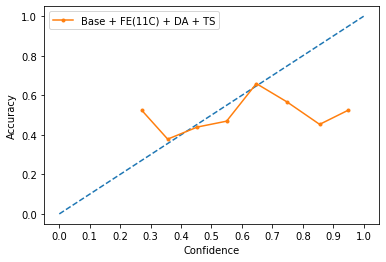

In [29]:
    for i in [60]:
        pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
        checkpoints = torch.load(pretrain_model)
        model.load_state_dict(checkpoints['state_dict'])
    
        # use cpu or cuda
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
    
        evaluate(args, data_const, model,seq, device, "D12", str(i), plot=True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


acc: 0.532325 map: 0.265036 loss: 14.353656, ece:0.200860, sce:0.036920, tace:0.040550, brier:0.687435, uce:0.192916


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


acc: 0.523384 map: 0.283751 loss: 13.764285, ece:0.168208, sce:0.039178, tace:0.038381, brier:0.714713, uce:0.173640


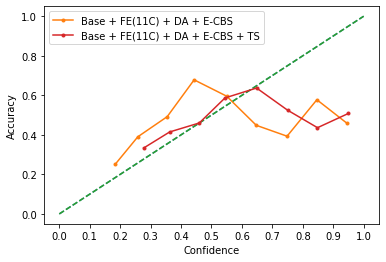

In [23]:
# ver = 'd2g_resnet18_11_cbs_ts'
# i = 60
# pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
# checkpoints = torch.load(pretrain_model)
# model1.load_state_dict(checkpoints['state_dict'])
    
# # use cpu or cuda
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model1.to(device)
    
# evaluate(args, data_const, model1,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA') 

# ver = 'd2g_t_resnet18_11_cbs_ts'
# i = 60
# pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
# checkpoints = torch.load(pretrain_model)
# model2.load_state_dict(checkpoints['state_dict'])
    
# # use cpu or cuda
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model2.to(device)
    
# evaluate(args, data_const, model2,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA + TS') 

# ver = 'd2g_cbs_resnet18_11_cbs_ts'
# i = 80
# pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
# checkpoints = torch.load(pretrain_model)
# model3.load_state_dict(checkpoints['state_dict'])
    
# # use cpu or cuda
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model3.to(device)
    
# evaluate(args, data_const, model3,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA + CBS') 

# ver = 'd2g_cbs_t_resnet18_11_cbs_ts'
# i = 80
# pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
# checkpoints = torch.load(pretrain_model)
# model4.load_state_dict(checkpoints['state_dict'])
    
# # use cpu or cuda
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model4.to(device)
    
# evaluate(args, data_const, model4,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA + CBS+ TS') 

ver = 'd2g_ecbs_resnet18_11_cbs_ts'
i = 60
pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
checkpoints = torch.load(pretrain_model)
model5.load_state_dict(checkpoints['state_dict'])
    
# use cpu or cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model5.to(device)
    
evaluate(args, data_const, model5,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA + E-CBS') 

ver = 'd2g_ecbs_t_resnet18_11_cbs_ts'
i = 70
pretrain_model = 'checkpoints/'+ver+'/'+ver+'/'+'epoch_train/checkpoint_D2F'+str(i)+'_epoch.pth'
checkpoints = torch.load(pretrain_model)
model6.load_state_dict(checkpoints['state_dict'])
    
# use cpu or cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model6.to(device)
    
evaluate(args, data_const, model6,seq, device, "D12", str(i), plot=True, plot_name = 'Base + FE(11C) + DA + E-CBS + TS') 


13